# Python機器學習與深度學習入門 期末專題

- <big>**題目：CNN 年齡預測**</big>
 
  <br>
 
- <big>**組員：吳易東**</big>

  <br>

- <big>**說明：**
    1. 目標 - 利用CNN判斷圖片中人物的年紀
    2. 資料來源 - https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ (用網址中的wiki資料庫)
</big>

## 1. Import API

In [2]:
%matplotlib inline
import scipy.io as sio  #import to read .mat files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import datetime
from keras.models import Sequential
from keras.layers import Dense, Activation, add, Conv2D, MaxPooling2D, Flatten, ReLU
from keras.optimizers import SGD, Adadelta, adam
from keras.utils import np_utils
from ipywidgets import interact_manual
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.models import model_from_json
from keras.layers import *
from keras import backend as K

Using TensorFlow backend.


## 2. Import DATA
* 因為資料佔6G，所以沒有放到github上，需要請到上面網址下載

In [2]:
path = 'DATASET/wiki/wiki'
dt = sio.loadmat(path)

### (圖片的metadata)

In [3]:
print('wiki.dob = {}'.format(dt['wiki'][0][0][0]))
print('wiki.photo_taken = {}'.format(dt['wiki'][0][0][1]))
print('wiki.full_path = {}'.format(dt['wiki'][0][0][2]))
print('wiki.gender = {}'.format(dt['wiki'][0][0][3]))
print('wiki.name = {}'.format(dt['wiki'][0][0][4]))
print('wiki.face_location = {}'.format(dt['wiki'][0][0][5]))
print('wiki.face_score = {}'.format(dt['wiki'][0][0][6]))
print('wiki.second_face_score = {}'.format(dt['wiki'][0][0][7]))

wiki.dob = [[723671 703186 711677 ... 720620 723893 713846]]
wiki.photo_taken = [[2009 1964 2008 ... 2013 2011 2008]]
wiki.full_path = [[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31')
  array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31')
  array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29') ...
  array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30')
  array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30')
  array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]]
wiki.gender = [[1. 1. 1. ... 1. 1. 0.]]
wiki.name = [[array(['Sami Jauhojärvi'], dtype='<U15')
  array(['Dettmar Cramer'], dtype='<U14')
  array(['Marc Okrand'], dtype='<U11') ...
  array(['Michael Wiesinger'], dtype='<U17')
  array(['Johann Grugger'], dtype='<U14')
  array(['Greta Van Susteren'], dtype='<U18')]]
wiki.face_location = [[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]])
  array([[252.4833023 , 126.68165115, 354.53192596, 228.73027481]])
  array([[113.52, 169.84, 366.08, 422.4

### > 試開一個圖片 <

age: 25
age: 25


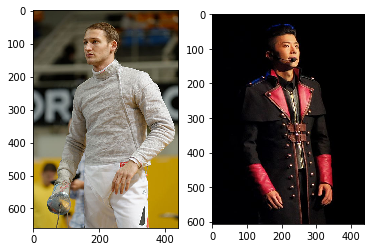

In [4]:
plt.subplot(1,2,1)
num = np.random.randint(60000)
I = Image.open('DATASET/wiki/'+dt['wiki'][0][0][2][0][num][0])
try:
    np.array(I).reshape(np.array(I).shape[0],np.array(I).shape[1],3)
    plt.imshow(I)
    print('age:',2015 - int(datetime.datetime.fromordinal(dt['wiki'][0][0][0][0][num]).strftime("%Y")))
except:
    pass
#---------------------------------------------#
plt.subplot(1,2,2)
num = np.random.randint(60000)
I = Image.open('DATASET/wiki/'+dt['wiki'][0][0][2][0][num][0])
try:
    np.array(I).reshape(np.array(I).shape[0],np.array(I).shape[1],3)
    plt.imshow(I)
    print('age:',2015 - int(datetime.datetime.fromordinal(dt['wiki'][0][0][0][0][num]).strftime("%Y")))
except:
    pass

---
## 3. 統計每張圖的平均長寬
- 505.827 row pixels
- 407.550 column pixels
- 共46945張圖可用

-> 設計每張圖的大小固定為 256x256x3

In [ ]:
row_avg = 0.0
col_avg = 0.0
total_num = 0.0
k = dt['wiki'][0][0][2][0]
for num, i in enumerate(k):
    if(num % 5000 == 0):
        print('Now: {}'.format(num))
    t = str(i[0]).replace(':', '_')
    try:
        img = Image.open('DATASET/wiki/' + t)
        I_NP = np.array(img)
        I_NP = I_NP.reshape(I_NP.shape[0],I_NP.shape[1],3)
    except:
        continue
    row_avg += np.array(img).shape[0]
    col_avg += np.array(img).shape[1]
    total_num += 1
print('DONE!')
print('平均每張圖有{}個row pixels, {}個col pixels, 共{}張圖'.format(
    row_avg/total_num, col_avg / total_num, total_num))

## 4. 設計每張圖片大小為256x256，讀取照片，轉換成numpy，並儲存(跑了快1天)

In [ ]:
total_pic = 46945.0
batch = 10000  #一次存10000張圖，一次存太多張memory不夠
row = 256
col = 256
now = 0
epoch = 0
pic = np.zeros((batch,row,col,3),dtype=np.uint8)  #紀錄圖片的numpy值
face_loc = np.zeros((batch,4), dtype=np.int)  #紀錄face的位置
face_num = np.zeros((batch,1), dtype=np.bool)  #紀錄圖中有幾張臉
gd = np.zeros((batch,1), dtype=np.bool)  #紀錄性別
age = np.zeros((batch,1), dtype=np.int)  #紀錄年紀(歲)
k = dt['wiki'][0][0][2][0]
for num, i in enumerate(k):
    if(num % 5000 == 0):
        print('Now: {}'.format(now))
    t = str(i[0]).replace(':','_')
    #print(t)
    try:
        I = Image.open('DATASET/wiki/' + t)
        I_NP = np.array(I)
        I_NP = I_NP.reshape(I_NP.shape[0], I_NP.shape[1], 3)
    except:
        print('Except Happen at {}'.format(num))
        continue
    r = I_NP.shape[0]-1
    c = I_NP.shape[1]-1
    r_ratio = r / float(row)
    c_ratio = c / float(col)
    # 壓縮 / 擴大 圖片
    for j in range(3):
        for m in range(row):
            for n in range(col):
                r1 = int(min(np.ceil(r_ratio*m),r))
                c1 = int(min(np.ceil(c_ratio*m),c))
                #print(r1, c1, I_NP[0][0][0])
                pic[now][m][n][j] = I_NP[r1][c1][j]
    # 判斷是否只有一張臉
    if(dt['wiki'][0][0][6][0][num] != float('-inf')):
        if(np.isnan(dt['wiki'][0][0][7][0][num])):
            face_loc[now][0] = dt['wiki'][0][0][5][0][num][0][0] / c_ratio
            face_loc[now][1] = dt['wiki'][0][0][5][0][num][0][1] / r_ratio
            face_loc[now][2] = dt['wiki'][0][0][5][0][num][0][2] / c_ratio
            face_loc[now][3] = dt['wiki'][0][0][5][0][num][0][3] / r_ratio
            face_num[now][0] = 1
    # 填入性別
    if(not np.isnan(dt['wiki'][0][0][3][0][num])):
        gd[now][0] = int(dt['wiki'][0][0][3][0][num])
    else:
        gd[now][0] = 0
    # 填入年紀
    if(type(dt['wiki'][0][0][0][0][num]) != np.int32):
        age[now] = 0
    else:
        age[now] = (2015 - int(datetime.datetime.fromordinal(dt['wiki'][0][0][0][0][num]).strftime("%Y")))
        
    now += 1
    if(now % batch == 0):
        np.save('pic{}-{}.npy'.format(epoch*batch, (epoch+1)*batch), 
                pic)
        np.save('face_loc{}-{}.npy'.format(epoch*batch, (epoch+1)*batch), 
                face_loc)
        np.save('face_num{}-{}.npy'.format(epoch*batch, (epoch+1)*batch), 
                face_num)
        np.save('gender{}-{}.npy'.format(epoch*batch, (epoch+1)*batch), 
                gd)
        np.save('age{}-{}.npy'.format(epoch*batch, (epoch+1)*batch), age)
        now = 0
        epoch += 1
        
np.save('pic{}-{}.npy'.format(epoch*batch, (epoch*batch+now)), pic[:now])
np.save('face_loc{}-{}.npy'.format(epoch*batch, (epoch*batch+now)), face_loc[:now])
np.save('face_num{}-{}.npy'.format(epoch*batch, (epoch*batch+now)), face_num[:now])
np.save('gender{}-{}.npy'.format(epoch*batch, (epoch*batch+now)),  gd[:now])
np.save('age{}-{}.npy'.format(epoch*batch, (epoch*batch+now)),age[:now])

## 5.看看training date的年齡分布

(array([  11.,  738., 8707., 9821., 4978., 4414., 3427., 2664., 1910.,
        1607.]),
 array([  4. ,  13.6,  23.2,  32.8,  42.4,  52. ,  61.6,  71.2,  80.8,
         90.4, 100. ]),
 <a list of 10 Patch objects>)

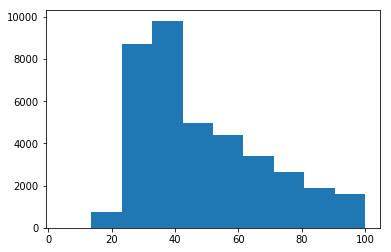

In [5]:
y = np.load('face_recog/age0-10000.npy')
y = np.append(y, np.load('face_recog/age10000-20000.npy'))
y = np.append(y, np.load('face_recog/age20000-30000.npy'))
y = np.append(y, np.load('face_recog/age30000-40000.npy'))
y = y[y<=100]
y = y[y>0]
plt.hist(y)

## 6.建造CNN
- 這裡只用到上面所存的pic和age

In [14]:
def mse2(y_true, y_pred):
    return K.mean(K.square(y_true-y_pred)*((K.abs(y_true-32.8) / 10.) + 0.5))

row = 256
col = 256
model = Sequential()
model.add(
    Conv2D(
        input_shape=(row,col,3),
        data_format = 'channels_last',
        filters = 50,
        kernel_size = (5,5), 
        strides = 1,
        activation = 'relu',
        )
    )
model.add(
    MaxPooling2D(
        pool_size = 5,
        strides = 1,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Conv2D(
        data_format = 'channels_last',
        filters = 40,
        kernel_size = (7,7), 
        strides = 1,
        activation = 'relu',
        )
   )
model.add(
    MaxPooling2D(
        pool_size = 3,
        strides = 1,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Conv2D(
        data_format = 'channels_last',
        filters = 30,
        kernel_size = (5,5), 
        strides = 2,
        activation = 'relu',
        )
   )
model.add(
    MaxPooling2D(
        pool_size = 3,
        strides = 1,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Conv2D(
        data_format = 'channels_last',
        filters = 16,
        kernel_size = (3,3), 
        strides = 1,
        activation = 'relu',
        )
   )
model.add(
    MaxPooling2D(
        pool_size = 5,
        strides = 2,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Conv2D(
        data_format = 'channels_last',
        filters = 8,
        kernel_size = (7,3), 
        strides = 1,
        activation = 'relu',
        )
   )
model.add(
    MaxPooling2D(
        pool_size = 3,
        strides = 1,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Conv2D(
        data_format = 'channels_last',
        filters = 8,
        kernel_size = (7,7), 
        strides = 2,
        activation = 'relu',
        )
   )
model.add(
    MaxPooling2D(
        pool_size = 3,
        strides = 1,
        padding = 'valid',
        data_format = 'channels_last'
        )
    )

model.add(
    Flatten(
        data_format = 'channels_last'
        )
    )

model.add(Dense(128, activation= 'relu'))

model.add(Dense(64, activation = 'tanh'))

model.add(Dense(16, activation = 'relu'))

model.add(Dense(4, activation = 'relu'))

model.add(Dense(1, activation = 'relu'))

model.summary()

model.compile(loss = mse2, optimizer = adam(),metrics = ['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 252, 252, 50)      3800      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 248, 248, 50)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 242, 242, 40)      98040     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 240, 240, 40)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 118, 118, 30)      30030     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 116, 116, 30)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 114, 114, 16)      4336      
__________

## 每次讀10000筆training data並訓練

In [15]:
##tatal_pic = 46945
tatal_pic = 40000
num_per_iter = 10000
batch_sizes = 1
now = 0
for i in range(4):
    try:
        del(num)
        del(x_train)
        del(y)
        del(y_cat)
        del(y_train)
    except:
        pass
    print('{} ~ {}:'.format(i*num_per_iter,(i+1)*num_per_iter))
    num = np.load('face_recog/face_num{}-{}.npy'.format(i*num_per_iter,(i+1)*num_per_iter))
    training_num = len(num[num == True])
    now_index = 0
    x_train = np.zeros((training_num,row,col,3), dtype=np.int8)
    x = np.load('face_recog/pic{}-{}.npy'.format(i*num_per_iter,(i+1)*num_per_iter))
    for m in range(10000):
        for n in range(3):
            x[m,:,:,n] = x[m,:,:,n] / np.max(x[m,:,:,n])
    
    y = np.load('face_recog/age{}-{}.npy'.format(i*num_per_iter,(i+1)*num_per_iter))
    y_cat = np.zeros((training_num,1), dtype=np.float)
    for n, i in enumerate(num):
        if((i[0] == True) and (y[n] <= 100) and (y[n] > 0)):
            y_cat[now_index] = y[n]
            x_train[now_index] = x[n]
            now_index += 1
    print(np.max(y_cat),np.min(y_cat))
    x_train = x_train[0:now_index]
    y_train = y_cat[0:now_index]
    cp = EarlyStopping(monitor='val_loss', patience = 2,
                      verbose=2)#, restore_best_weights=True)
    print('Start training...')
    model.fit(x_train,y_train,batch_size=batch_sizes,epochs = 5, callbacks=[cp], validation_split=0.1)


0 ~ 10000:
100.0 0.0
Start training...
Train on 6587 samples, validate on 732 samples
Epoch 1/5
6587/6587 [==============================] - 2369s 360ms/step - loss: 1556.5590 - acc: 0.0102 - val_loss: 1116.3343 - val_acc: 0.0123
Epoch 2/5
6587/6587 [==============================] - 2376s 361ms/step - loss: 1089.5609 - acc: 0.0114 - val_loss: 1025.2085 - val_acc: 0.0096
Epoch 3/5
6587/6587 [==============================] - 2403s 365ms/step - loss: 1046.1467 - acc: 0.0108 - val_loss: 1005.5421 - val_acc: 0.0068
Epoch 4/5
6587/6587 [==============================] - 2398s 364ms/step - loss: 1043.4517 - acc: 0.0108 - val_loss: 1021.3916 - val_acc: 0.0096
Epoch 5/5
6587/6587 [==============================] - 2394s 363ms/step - loss: 1043.7652 - acc: 0.0100 - val_loss: 1005.9326 - val_acc: 0.0068
Epoch 00005: early stopping
10000 ~ 20000:
100.0 0.0
Start training...
Train on 8127 samples, validate on 904 samples
Epoch 1/5
8127/8127 [==============================] - 2948s 363ms/step - lo

KeyboardInterrupt: 

## 儲存Model

In [ ]:
model_json = model.to_json()
open('Model/pred.json','w').write(model_json)
model.save_weights('Model/pred_weights.h5')

## 讀取Model

In [3]:
pred_model = model_from_json(open('Model/pred.json').read())
pred_model.load_weights('Model/pred_weights.h5')
pred_model.compile(loss = 'mse',optimizer = adam(),)

## 隨便從網路上找相片看看是否準確

Picture 0 預測年齡: 24 歲
Picture 1 預測年齡: 16 歲
Picture 2 預測年齡: 38 歲
Picture 3 預測年齡: 43 歲
Picture 4 預測年齡: 22 歲
Picture 5 預測年齡: 36 歲
Picture 6 預測年齡: 23 歲


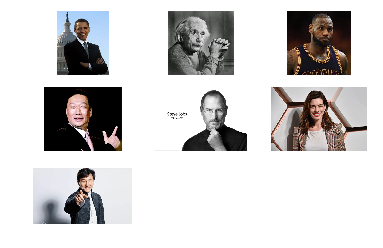

In [7]:
row = 256
col = 256
test_num = 7
test = np.zeros((test_num,row,col,3))
now = 0
for i in range(1,test_num+1):
    try:
        I = Image.open('TESTING/' + str(i) + '.jpg')
        plt.subplot(3,3,i)
        plt.axis('off')
        plt.imshow(I)
        I_NP = np.array(I)
        I_NP = I_NP.reshape(I_NP.shape[0], I_NP.shape[1], 3)
    except:
        print(i)
        continue
    r = I_NP.shape[0]-1
    c = I_NP.shape[1]-1
    r_ratio = r / float(row)
    c_ratio = c / float(col)
    # 壓縮 / 擴大 圖片
    for j in range(3):
        for m in range(row):
            for n in range(col):
                r1 = int(min(np.ceil(r_ratio*m),r))
                c1 = int(min(np.ceil(c_ratio*m),c))
                test[now][m][n][j] = I_NP[r1][c1][j]
    now+=1

for i in range(test_num):
    for j in range(3):
        test[i,:,:,j] = test[i,:,:,j] / np.max(test[i,:,:,j])
    print('Picture',i,'預測年齡:', int(pred_model.predict(test[i:i+1])[0][0]),'歲')


---
## 結論
1. Training data的照片很多的頭部比例小，感覺比較難準確判斷年紀
2. 因為開256x256的矩陣來訓練，所以建多層CNN的表現比較好
3. 很多次訓練完的Model拿來預測時，不管是送什麼圖片進去，結果都是一樣的，不知道為什麼會這樣